In [1]:
# working environment
!nvidia-smi

Wed Apr 12 14:11:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   49C    P0              149W / 390W|    227MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>Import the necessary libraries</font>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools 

2023-04-12 14:11:25.780267: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-12 14:11:25.817375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>Fashion-MNIST is a popular benchmark dataset used in machine learning and computer vision tasks. It consists of a set of grayscale images of 10 different categories of fashion items, such as t-shirts, trousers, dresses, coats, sandals, sneakers, bags, ankle boots, etc. Each image in the dataset is a 28x28 pixel image, and there are 60,000 images in the training set and 10,000 images in the test set.</font>
 
    Fashion-MNIST is often used as a replacement for the original MNIST dataset, which consists of handwritten digits, as it provides a more challenging and realistic task for image classification algorithms. It was introduced as a drop-in replacement for MNIST to address some of its limitations, such as being too easy for modern machine learning algorithms and lacking diversity in image content.

    The Fashion-MNIST dataset is widely used for tasks such as image classification, object recognition, and fashion item recommendation. It is commonly used as a benchmark dataset for evaluating the performance of various machine learning models, including deep learning models, convolutional neural networks (CNNs), and other image recognition algorithms. It has become a standard dataset for researchers and practitioners in the field of computer vision and machine learning to evaluate and compare the performance of different models on a common task.

## <font color='red'>To begin, let's import the dataset from the TensorFlow library.</font>

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## <font color='red'>I will display some example images from the Fashion-MNIST dataset.</font>

In [5]:
def display_mnist_images(images, labels, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3))
    axes = axes.ravel()

    for i in np.arange(0, rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])

    plt.subplots_adjust(hspace=0.5)
    plt.show()

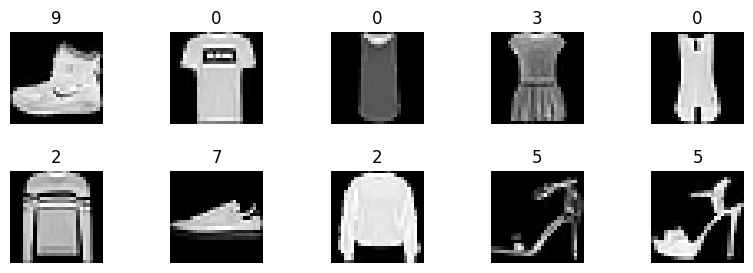

In [6]:
display_mnist_images(train_images[:10], train_labels[:10], rows=2, cols=5)

## <font color='red'>Before training, we need to preprocess the Fashion-MNIST dataset and convert it into a tensor dataset. Let's perform these preprocessing steps.</font>

In [10]:
def preprocess(img, lbl):
    img = tf.reshape(img, img.shape + [1])
    img = tf.keras.layers.Rescaling(1./255.)(img)  
    return img, lbl

In [11]:
train = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE).cache()
test = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

## <font color='red'>Now, let's define the architecture of our model.</font>

    Here, we will implement a parallel layer architecture with multiple branches of inputs, which will be concatenated later to see the results at the end.

In [12]:
inputs = tf.keras.layers.Input(shape=list(train_images[0].shape) + [1]) 

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x_1 = tf.keras.layers.MaxPooling2D((2, 2))(x) 
x_1 = tf.keras.layers.BatchNormalization()(x_1) 

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x_2 = tf.keras.layers.MaxPooling2D((2, 2))(x)  

x = tf.keras.layers.Concatenate()([x_1, x_2])
x = tf.keras.layers.Dense(32, activation="relu")(x) 
x = tf.keras.layers.Flatten()(x) 

x = tf.keras.layers.BatchNormalization()(x) 
x = tf.keras.layers.Dense(256, activation="relu")(x) 

x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(set(train_labels)), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs) 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

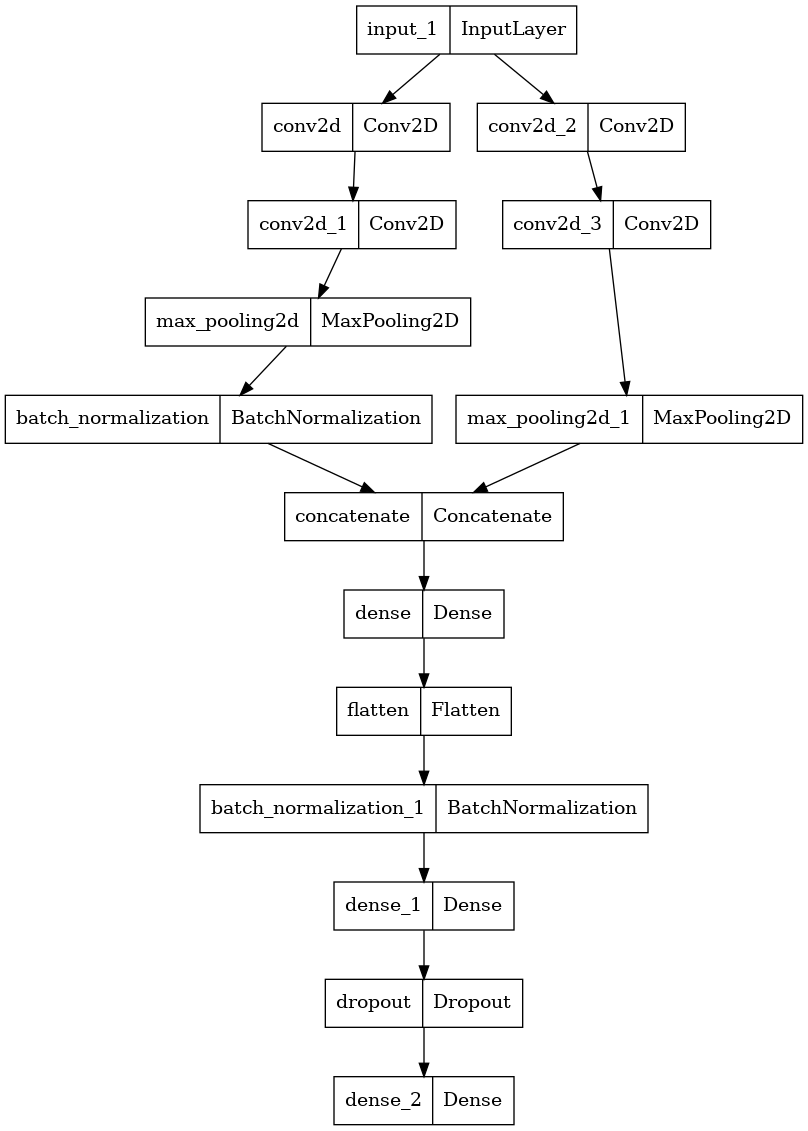

In [22]:
tf.keras.utils.plot_model(model)

## <font color='red'>Let's train our model.</font>

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)

In [15]:
model_history = model.fit(train, epochs=50, validation_data=test, validation_steps=len(test) * 0.2, callbacks=[early_stop])

Epoch 1/50


2023-04-12 14:12:18.185272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-04-12 14:12:20.379328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-12 14:12:21.058787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-12 14:12:21.062913: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x358508d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-12 14:12:21.062966: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-12 

1872/1875 [============================>.] - ETA: 0s - loss: 0.5280 - accuracy: 0.8287

2023-04-12 14:12:42.327953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]


1875/1875 [==============================] - 24s 11ms/step - loss: 0.5276 - accuracy: 0.8288 - val_loss: 0.3693 - val_accuracy: 0.8829
Epoch 2/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3347 - accuracy: 0.8782 - val_loss: 0.3362 - val_accuracy: 0.8919
Epoch 3/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2956 - accuracy: 0.8928 - val_loss: 0.3763 - val_accuracy: 0.8968
Epoch 4/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2715 - accuracy: 0.9025 - val_loss: 0.3153 - val_accuracy: 0.9013
Epoch 5/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2492 - accuracy: 0.9092 - val_loss: 0.2627 - val_accuracy: 0.9122
Epoch 6/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2284 - accuracy: 0.9169 - val_loss: 0.3411 - val_accuracy: 0.9137
Epoch 7/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2157 - accuracy: 0.9216 - val_loss: 0.3406 - val_accura

## <font color='red'>Let's save the trained model in the h5 format.</font>

In [16]:
model.save("saved-model.h5")

In [17]:
!ls saved-model.h5

saved-model.h5


## <font color='red'>Let's evaluate the performance of our model.</font>

In [18]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=12)
    plt.yticks(fontsize=12)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [19]:
load_saved_model = tf.keras.models.load_model("saved-model.h5")

In [21]:
perf = load_saved_model.evaluate(test)
print("Testing accuracy: ", perf[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.3295 - accuracy: 0.9048
Testing accuracy:  0.9047999978065491


313/313 [==============================] - 1s 4ms/step


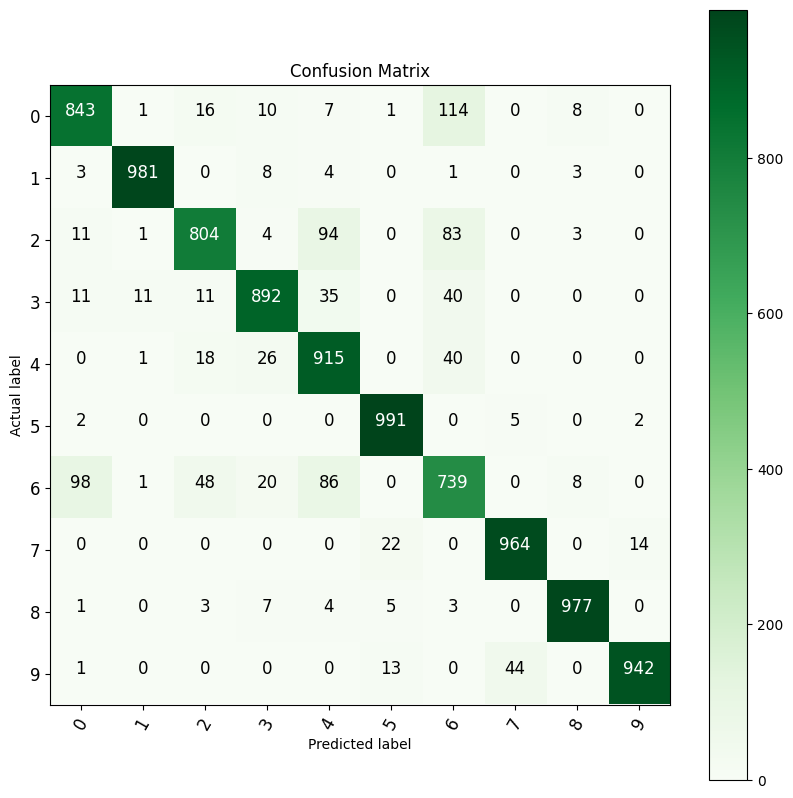

In [20]:
conf_matrix(y_test=test_labels, y_pred=load_saved_model.predict(test).argmax(axis=1), class_names=list(set(train_labels)))